# k nearest neighbor algorithm

## Idea's are pulled from this [course](https://web.eecs.umich.edu/~justincj/teaching/eecs498/FA2019/)

In [3]:
import torch 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data and Dataloaders

In [5]:
from pathlib import Path

data_path = Path('../data')
data_path.mkdir(exist_ok=True)

In [6]:
from torchvision import datasets, transforms

train_dataset = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

test_dataset = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [7]:
train_dataset, test_dataset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ../data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ../data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [9]:
for Xtr, ytr in train_dataloader:
    x_train, y_train = Xtr.to(device), ytr.to(device)
    print(x_train.shape, y_train.shape)
    
for Xte, yte in test_dataloader:
    x_test, y_test = Xte.to(device), yte.to(device)
    print(x_test.shape, y_test.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])
torch.Size([10000, 3, 32, 32]) torch.Size([10000])


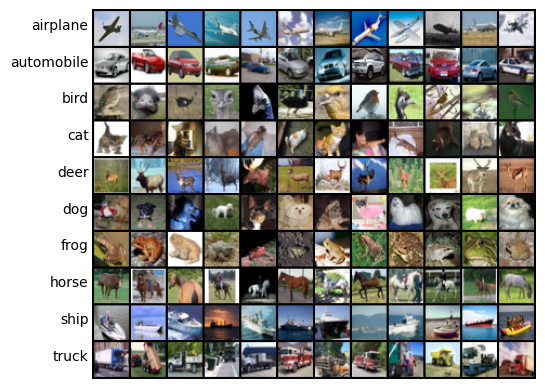

In [10]:
# visualization on train dataset
import random
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

classes = train_dataset.classes
samples_per_class = 12
samples = []
    
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs = (y_train == y).nonzero().view(-1)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(x_train[idx])
        
img = make_grid(samples, nrow=samples_per_class).cpu()
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

## Subsampling data for experimentation

In [11]:
%%script false --no-raise-error

# x_train = x_train[:500]
# y_train = y_train[:500]

# x_test = x_test[:250]
# y_test = y_test[:250]

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)

print('Testing set:', )
print('  data shape:', x_test.shape)
print('  labels shape: ', y_test.shape)

## Compute Euclidean distances

$L1$ distance for each image $I_1$ and $I_2$
$$d_1(I_1, I_2) = \sum_p |I_{1}^{p} - I_{2}^{p}|$$

$L2$ distance for each image $I_1$ and $I_2$
$$d_2(I_1, I_2) = \sqrt{\sum_p (I_{1}^{p} - I_{2}^{p})^2}$$


In [12]:
def compute_distances_two_loops(x_train, x_test):
	"""
	Computes the L2 Euclidean distance between each element of the test
	set and each element of the train set. Images should be flattened and treated
	as vectors.

	This implementation uses a naive set of nested loops over the test and
	train data.

	Inputs:
	- x_train: Torch tensor of shape (num_train, C, H, W)
	- x_test: Torch tensor of shape (num_test, C, H, W)

	Returns:
	- dists: Torch tensor of shape (num_test, num_train) where dists[i] is the row of distances
		between x_test[i] - x_train
	"""
	num_train = x_train.shape[0]
	num_test = x_test.shape[0]
 
	x_train = x_train.reshape(num_train, -1)
	x_test = x_test.reshape(num_test, -1)

	dists = x_train.new_zeros(num_test, num_train)

	for i in range(num_test):
		for j in range(num_train):
			dists[i, j] = torch.sqrt(torch.pow(x_test[i] - x_train[j], 2).sum(dim=-1))
   
	assert dists.shape == (num_test, num_train)
			
	return dists

In [13]:
%%script false --no-raise-error

dists = compute_distances_two_loops(x_train, x_test)
dists.shape

In [14]:
%%script false --no-raise-error

plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('train')
plt.ylabel('test')
plt.show()

In [15]:
def compute_distances_one_loop(x_train, x_test):
	"""
	Computes the L2 Euclidean distance between each element of the test
	set and each element of the train set. Images should be flattened and treated
	as vectors.

	This implementation uses only a single loop over the test data.

	Inputs:
	- x_train: Torch tensor of shape (num_train, C, H, W)
	- x_test: Torch tensor of shape (num_test, C, H, W)

	Returns:
	- dists: Torch tensor of shape (num_test, num_train) where dists[i] is the row of distances
		between x_test[i] - x_train
	"""

	num_train = x_train.shape[0]
	num_test = x_test.shape[0]
 
	x_train = x_train.reshape(num_train, -1)
	x_test = x_test.reshape(num_test, -1)
 
	dists = x_train.new_zeros(num_test, num_train)

	for i in range(num_test):
		dists[i] = torch.sqrt(torch.pow(x_test[i] - x_train, 2).sum(dim=-1))
   
	assert dists.shape == (num_test, num_train)
			
	return dists

In [16]:
%%script false --no-raise-error

dists = compute_distances_one_loop(x_train, x_test)
dists.shape

We can check the correctness of our one-loop implementation by comparing it with our two-loop implementation on some randomly generated data. Note that we do the comparison with 64-bit floating points for increased numeric precision.

In [17]:
%%script false --no-raise-error

torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 64, 64, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 64, 64, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)

difference = torch.sqrt(torch.pow(dists_one - dists_two, 2).sum()).item()

print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('Uh-oh! The distance matrices are different')

In [18]:
# TODO

def compute_distances_no_loops(x_train, x_test):
	"""
	Computes the L2 Euclidean distance between each element of the test
	set and each element of the train set. Images should be flattened and treated
	as vectors.

	This implementation should not use any Python loops. For memory-efficiency,
	it also should not create any large intermediate tensors; in particular you
	should not create any intermediate tensors with O(num_train*num_test)
	elements.

	Inputs:
	- x_train: Torch tensor of shape (num_train, C, H, W)
	- x_test: Torch tensor of shape (num_test, C, H, W)

	Returns:
	- dists: Torch tensor of shape (num_test, num_train) where dists[i] is the row of distances
		between x_test[i] - x_train
	"""

	num_train = x_train.shape[0]
	num_test = x_test.shape[0]
 
	x_train = x_train.reshape(num_train, -1)
	x_test = x_test.reshape(num_test, -1)
 
	dists = x_train.new_zeros(num_test, num_train)

	for i in range(num_test):
		dists[i] = torch.sqrt(torch.pow(x_test[i] - x_train, 2).sum(dim=-1))
   
	assert dists.shape == (num_test, num_train)
			
	return dists

### Time it

In [19]:
%%script false --no-raise-error

import time

def timeit(f, *args):
	tic = time.time()
	f(*args) 
	toc = time.time()
	return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print(f'Two loop version took {two_loop_time:.2f} seconds')

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print(f'One loop version took {one_loop_time:.2f} seconds ({speedup:.1f}X speedup)')

## Implementation of KNN

In [20]:
class KnnClassifier:
    def __init__(self, x_train, y_train):
        """
        Create a new K-Nearest Neighbor classifier with the specified training data.
        In the initializer we simply memorize the provided training data.

        Inputs:
        - x_train: Torch tensor of shape (num_train, C, H, W) giving training data
        - y_train: int64 torch tensor of shape (num_train,) giving training labels
        """
        
        self.num_train = x_train.shape[0]
        self.x_train = x_train.reshape(self.num_train, -1).contiguous()
        self.y_train = y_train.contiguous()
        
        
    def predict(self, x_test, k=1):
        """
        Make predictions using the classifier.

        Inputs:
        - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
        - k: The number of neighbors to use for predictions

        Returns:
        - y_test_pred: Torch tensor of shape (num_test,) giving predicted labels
            for the test samples.
        """
        self.num_test = x_test.shape[0]
        self.x_test = x_test.reshape(self.num_test, -1).contiguous()
        
        def predict_labels(dists, y_test, k=1):
            y_pred = torch.zeros(self.num_test, dtype=torch.int64).to(device)
            for i in range(self.num_test):
                _, indices = torch.topk(dists[i], k=k, largest=False)
                neighbor_labels = y_test[indices]
                counts = torch.bincount(neighbor_labels)
                max_counts = torch.max(counts)
                max_labels = torch.nonzero(counts == max_counts).flatten()
                
                if len(max_labels) > 1:
                    y_pred[i] = max_labels.min().item()
                else:
                    y_pred[i] = max_labels.item()
            return y_pred

        
        dists = torch.cdist(self.x_test, self.x_train)
        y_pred = predict_labels(dists, self.y_train, k=k)
        
        return y_pred
  
    def check_accuracy(self, x_test, y_test, k=1, quiet=False):
        """
        Utility method for checking the accuracy of this classifier on test data.
        Returns the accuracy of the classifier on the test data, and also prints a
        message giving the accuracy.

        Inputs:
        - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
        - y_test: int64 torch tensor of shape (num_test,) giving test labels
        - k: The number of neighbors to use for prediction
        - quiet: If True, don't print a message.

        Returns:
        - accuracy: Accuracy of this classifier on the test data, as a percent.
            Python float in the range [0, 100]
        """
        y_test = y_test
        y_pred = self.predict(x_test, k=k)
        num_samples = self.num_test
        num_correct = (y_test == y_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        
        if not quiet:
            print(f'Got {num_correct} / {num_samples} correct; Accuracy is {accuracy:.2f}%')
            
        return accuracy

## Cross Validation

In [21]:
def knn_cross_validate(x_train, y_train, num_folds=5, k_choices=None, quiet=False):
    """
    Perform cross-validation for KnnClassifier.

    Inputs:
    - x_train: Tensor of shape (num_train, C, H, W) giving all training data
    - y_train: int64 tensor of shape (num_train,) giving labels for training data
    - num_folds: Integer giving the number of folds to use
    - k_choices: List of integers giving the values of k to try
    - quiet: If True, don't print a message.

    Returns:
    - k_to_accuracies: Dictionary mapping values of k to lists, where
    k_to_accuracies[k][i] is the accuracy on the ith fold of a KnnClassifier
    that uses k nearest neighbors.
    """
    if k_choices is None:
        # Use default values
        k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

    x_train_folds = torch.chunk(x_train, num_folds)
    y_train_folds = torch.chunk(y_train, num_folds)

    k_to_accuracies = {}
    for k in k_choices:
        k_to_accuracies[k] = []
        print(f"k = {k}: ")
        
        for i in range(num_folds):
            x_train = torch.cat(x_train_folds[:i] + x_train_folds[i+1:])
            y_train = torch.cat(y_train_folds[:i] + y_train_folds[i+1:])
            
            x_test = x_train_folds[i]
            y_test = y_train_folds[i]
            
            model = KnnClassifier(x_train, y_train)
            accuracy = model.check_accuracy(x_test, y_test, k=k, quiet=quiet)
            
            k_to_accuracies[k].append(accuracy)
            
    return k_to_accuracies

In [22]:
k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
    print('k = %d got accuracies: %r' % (k, accs))

k = 1: 
Got 3401 / 10000 correct; Accuracy is 34.01%
Got 3404 / 10000 correct; Accuracy is 34.04%
Got 3443 / 10000 correct; Accuracy is 34.43%
Got 3405 / 10000 correct; Accuracy is 34.05%
Got 3392 / 10000 correct; Accuracy is 33.92%
k = 3: 
Got 3204 / 10000 correct; Accuracy is 32.04%
Got 3257 / 10000 correct; Accuracy is 32.57%
Got 3283 / 10000 correct; Accuracy is 32.83%
Got 3241 / 10000 correct; Accuracy is 32.41%
Got 3267 / 10000 correct; Accuracy is 32.67%
k = 5: 
Got 3280 / 10000 correct; Accuracy is 32.80%
Got 3317 / 10000 correct; Accuracy is 33.17%
Got 3354 / 10000 correct; Accuracy is 33.54%
Got 3308 / 10000 correct; Accuracy is 33.08%
Got 3343 / 10000 correct; Accuracy is 33.43%
k = 8: 
Got 3228 / 10000 correct; Accuracy is 32.28%
Got 3348 / 10000 correct; Accuracy is 33.48%
Got 3319 / 10000 correct; Accuracy is 33.19%
Got 3310 / 10000 correct; Accuracy is 33.10%
Got 3382 / 10000 correct; Accuracy is 33.82%
k = 10: 
Got 3231 / 10000 correct; Accuracy is 32.31%
Got 3355 / 100

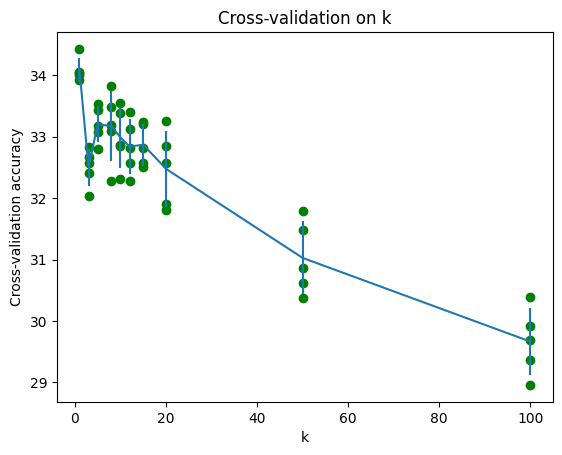

In [23]:
ks, means, stds = [], [], []
for k, accs in sorted(k_to_accuracies.items()):
    plt.scatter([k] * len(accs), accs, color='g')
    ks.append(k)
    means.append(torch.tensor(accs).mean())
    stds.append(torch.tensor(accs).std())

plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

In [24]:
best_k = ks[torch.tensor(means).argmax()]
best_k

1

## Evaluation

In [25]:
model = KnnClassifier(x_train, y_train)

model.check_accuracy(x_test, y_test, k=best_k)

Got 3541 / 10000 correct; Accuracy is 35.41%


35.41